# Elo Score Calculation

In [54]:
import re
import os
from collections import defaultdict

In [41]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [47]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [4]:
tube_test_df = pd.read_csv("../../data/tube_test_fights.csv")

In [5]:
tube_test_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,NaN,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4


## Doing it for a subset of the data

- To test out the code, we will be using the data from only one cage

In [6]:
# Getting all the rows that are from cage 1
cage_1_df = tube_test_df[tube_test_df["cage"] == 1]

In [7]:
cage_1_df

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,NaN,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
5,1,1.1 v 2.3,2.3,1.1,1.1,1.1,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1


## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [8]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


In [9]:
print(get_all_animal_ids("1.1 v 2.3"))

('1.1', '2.3')


- Turning all the columns into string so that we can match the ID's from one column to another

In [10]:
for col in cage_1_df.columns:
    cage_1_df[col] = cage_1_df[col].astype(str)

/tmp/ipykernel_143559/4260518769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cage_1_df[col] = cage_1_df[col].astype(str)


In [11]:
cage_1_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,nan,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,nan,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4


In [12]:
cage_1_df["all_animals"] = cage_1_df["animal"].apply(lambda x: get_all_animal_ids(x))

/tmp/ipykernel_143559/1018194899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cage_1_df["all_animals"] = cage_1_df["animal"].apply(lambda x: get_all_animal_ids(x))


In [13]:
cage_1_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May,all_animals
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,nan,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,"(1.1, 2.2)"
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,nan,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,"(2.2, 2.3)"
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.3, 1.4)"
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(1.4, 1.1)"
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.2, 1.4)"


## Elo Score Calculation

In [14]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

In [15]:
calculate_elo_score(subject_elo_score=1500, agent_elo_score=500, score=0)

1480

## Calculate all the Elo scores for this cage

In [16]:
cage_1_df.columns

Index(['cage', 'animal', '25-Apr', '26-Apr', '27-Apr', '28-Apr', '29-Apr',
       '2-May', '4-May', '5-May', '6-May', '9-May', '10-May', '11-May',
       '12-May', '13-May', '20-May', 'all_animals'],
      dtype='object')

In [17]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))
for column in cage_1_df:
    if column not in ['cage', 'animal', 'all_animals']:
        print("Current Date: {}".format(column))
        # Keeping track of the number of matches
        id_to_match_number = defaultdict(lambda:1)
        for index, row in cage_1_df.iterrows():
            # Checking if there is an Nan or not
            if row[column] == "nan":
                continue
            else:            
                winner_id = row[column]

            # Getting the ID of the loser subject
            loser_id = list(set(row["all_animals"]) - set([winner_id]))
            loser_id = loser_id[0]
            # Getting the current Elo Score
            current_winner_rating = id_to_elo_score[winner_id] 
            current_loser_rating = id_to_elo_score[loser_id] 
            # Calculating Elo score            
            id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1)
            id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0)
            
            # Saving all the data for the winner
            winner_index = next(all_indexes)
            index_to_elo_score_and_meta_data[winner_index]["date"] = column
            index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[winner_id]
            index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
            index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
            index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
            index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
            index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1
            
            # Saving all the data for the loser
            loser_index = next(all_indexes)
            index_to_elo_score_and_meta_data[loser_index]["date"] = column
            index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[loser_id]
            index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
            index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
            index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
            index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
            index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0
            
            id_to_match_number[winner_id] += 1
            id_to_match_number[loser_id] += 1
        break
    

Current Date: 25-Apr


# Calculate Elo score for all cells

In [18]:
for col in tube_test_df.columns:
    tube_test_df[col] = tube_test_df[col].astype(str)

In [19]:
rename_dates_dict = {"25-Apr": "2022/04/25",  "26-Apr": "2022/04/26",  "27-Apr": "2022/04/27",  "28-Apr": "2022/04/28",  "29-Apr": "2022/04/29",  "2-May": "2022/05/02", "4-May": "2022/05/04", "5-May": "2022/05/05", "6-May": "2022/05/06", "9-May": "2022/05/09", "10-May": "2022/05/10", "11-May": "2022/05/11", "12-May": "2022/05/12", "13-May": "2022/05/13",  "20-May": "2022/05/20"}

In [20]:
tube_test_df = tube_test_df.rename(columns=rename_dates_dict)

In [21]:
tube_test_df.head()

,cage,animal,2022/04/25,2022/04/26,2022/04/27,2022/04/28,2022/04/29,2022/05/02,2022/05/04,2022/05/05,2022/05/06,2022/05/09,2022/05/10,2022/05/11,2022/05/12,2022/05/13,2022/05/20
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,nan,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,nan,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4


In [22]:
tube_test_df["all_animals"] = tube_test_df["animal"].apply(lambda x: get_all_animal_ids(x))

## Get the Elo score for one fight

In [23]:
tube_test_df.columns

Index(['cage', 'animal', '2022/04/25', '2022/04/26', '2022/04/27',
       '2022/04/28', '2022/04/29', '2022/05/02', '2022/05/04', '2022/05/05',
       '2022/05/06', '2022/05/09', '2022/05/10', '2022/05/11', '2022/05/12',
       '2022/05/13', '2022/05/20', 'all_animals'],
      dtype='object')

In [24]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))
for column in tube_test_df:
    if column not in ['cage', 'animal', 'all_animals']:
        print("Current Date: {}".format(column))
        # Keeping track of the number of matches
        id_to_match_number = defaultdict(lambda:1)
        for index, row in tube_test_df.iterrows():
            # Checking if there is an Nan or not
            if row[column] == "nan":
                continue
            else:            
                winner_id = row[column]

            # Getting the ID of the loser subject
            loser_id = list(set(row["all_animals"]) - set([winner_id]))
            loser_id = loser_id[0]
            # Getting the current Elo Score
            current_winner_rating = id_to_elo_score[winner_id] 
            current_loser_rating = id_to_elo_score[loser_id] 
            # Calculating Elo score            
            id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=1, number_of_decimals=1)
            id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=0, number_of_decimals=1)
            
            # Saving all the data for the winner
            winner_index = next(all_indexes)
            index_to_elo_score_and_meta_data[winner_index]["date"] = column
            index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[winner_id]
            index_to_elo_score_and_meta_data[winner_index]["cage"] = row["cage"]
            index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
            index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
            index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
            index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
            index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = 1
            
            
            # Saving all the data for the loser
            loser_index = next(all_indexes)
            index_to_elo_score_and_meta_data[loser_index]["date"] = column
            index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[loser_id]
            index_to_elo_score_and_meta_data[loser_index]["cage"] = row["cage"]
            index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
            index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
            index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
            index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
            index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = 0
            
            id_to_match_number[winner_id] += 1
            id_to_match_number[loser_id] += 1
    

Current Date: 2022/04/25
Current Date: 2022/04/26
Current Date: 2022/04/27
Current Date: 2022/04/28
Current Date: 2022/04/29
Current Date: 2022/05/02
Current Date: 2022/05/04
Current Date: 2022/05/05
Current Date: 2022/05/06
Current Date: 2022/05/09
Current Date: 2022/05/10
Current Date: 2022/05/11
Current Date: 2022/05/12
Current Date: 2022/05/13
Current Date: 2022/05/20


In [25]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {'1.1': 1065.7,
             '2.2': 937.8,
             '2.3': 778.9,
             '1.4': 1238.0,
             '1.2': 937.4,
             '1.3': 781.4,
             '2.4': 1145.0,
             '2.1': 1115.8,
             '3.2': 1228.3,
             '4.2': 1082.2,
             '3.3': 905.0,
             '4.1': 784.5,
             '4.3': 1110.6,
             '3.4': 1129.5,
             '3.1': 981.9,
             '4.4': 778.0})

In [26]:
index_to_elo_score_and_meta_data[0]

{'date': '2022/04/25',
 'match_number': 1,
 'cage': '1',
 'subject_id': '1.1',
 'agent_id': '2.2',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1}

In [27]:
elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [28]:
elo_score_df.head(n=25)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022/04/25,1,1,1.1,2.2,1000.0,1010.0,1
1,2022/04/25,1,1,2.2,1.1,1000.0,990.0,0
2,2022/04/25,2,1,2.2,2.3,990.0,1000.3,1
3,2022/04/25,1,1,2.3,2.2,1000.0,989.7,0
4,2022/04/25,1,1,1.4,2.3,1000.0,1009.7,1
5,2022/04/25,2,1,2.3,1.4,989.7,980.0,0
6,2022/04/25,2,1,1.4,1.1,1009.7,1019.7,1
7,2022/04/25,2,1,1.1,1.4,1010.0,1000.0,0
8,2022/04/25,3,1,1.4,2.2,1019.7,1029.1,1
9,2022/04/25,3,1,2.2,1.4,1000.3,990.9,0


## Making the Dates into Numbers

In [29]:
# Given timestamp in string
time_str = '2021/7/24 11'
date_format_str = '%Y/%m/%d %H'
# create datetime object from timestamp string
given_time = datetime.strptime(time_str, date_format_str)

In [30]:
print(given_time)

2021-07-24 11:00:00


In [31]:
elo_score_df["date_with_hour"] = elo_score_df["date"].astype(str) + " " + elo_score_df["match_number"].astype(str)

In [32]:
elo_score_df.head()

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date_with_hour
0,2022/04/25,1,1,1.1,2.2,1000.0,1010.0,1,2022/04/25 1
1,2022/04/25,1,1,2.2,1.1,1000.0,990.0,0,2022/04/25 1
2,2022/04/25,2,1,2.2,2.3,990.0,1000.3,1,2022/04/25 2
3,2022/04/25,1,1,2.3,2.2,1000.0,989.7,0,2022/04/25 1
4,2022/04/25,1,1,1.4,2.3,1000.0,1009.7,1,2022/04/25 1


In [33]:
elo_score_df["date_time"] = elo_score_df["date_with_hour"].apply(lambda x: datetime.strptime(x, date_format_str))

In [34]:
print(given_time)

2021-07-24 11:00:00


In [35]:
elo_score_df

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,date_with_hour,date_time
0,2022/04/25,1,1,1.1,2.2,1000.0,1010.0,1,2022/04/25 1,2022-04-25 01:00:00
1,2022/04/25,1,1,2.2,1.1,1000.0,990.0,0,2022/04/25 1,2022-04-25 01:00:00
2,2022/04/25,2,1,2.2,2.3,990.0,1000.3,1,2022/04/25 2,2022-04-25 02:00:00
3,2022/04/25,1,1,2.3,2.2,1000.0,989.7,0,2022/04/25 1,2022-04-25 01:00:00
4,2022/04/25,1,1,1.4,2.3,1000.0,1009.7,1,2022/04/25 1,2022-04-25 01:00:00
...,...,...,...,...,...,...,...,...,...,...
669,2022/05/20,2,4,4.4,3.4,783.1,780.6,0,2022/05/20 2,2022-05-20 02:00:00
670,2022/05/20,3,4,4.3,4.4,1108.0,1110.6,1,2022/05/20 3,2022-05-20 03:00:00
671,2022/05/20,3,4,4.4,4.3,780.6,778.0,0,2022/05/20 3,2022-05-20 03:00:00
672,2022/05/20,3,4,3.4,3.1,1123.2,1129.5,1,2022/05/20 3,2022-05-20 03:00:00


In [37]:
elo_score_df.to_csv("./proc/tube_test_elo_score.csv")
# elo_score_df.to_excel("./proc/id_to_date_elo_score.xlsx")

In [62]:
earliest_date = elo_score_df["date"].min()

In [63]:
earliest_date = earliest_date.replace("/", "_")

In [64]:
latest_date = elo_score_df["date"].max()

In [65]:
latest_date = latest_date.replace("/", "_")

In [66]:
earliest_date

'2022_04_25'

In [67]:
latest_date

'2022_05_20'

## Plotting the Scores

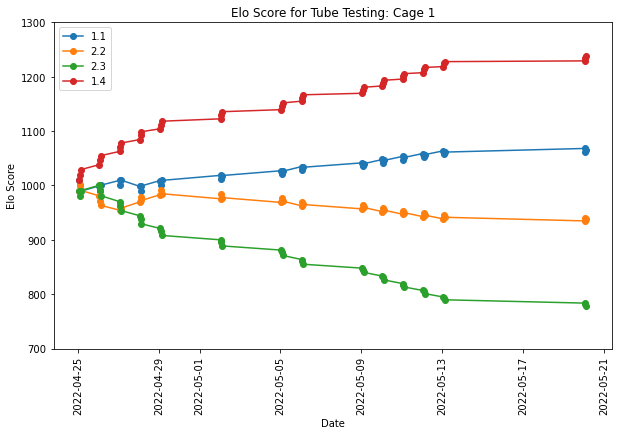

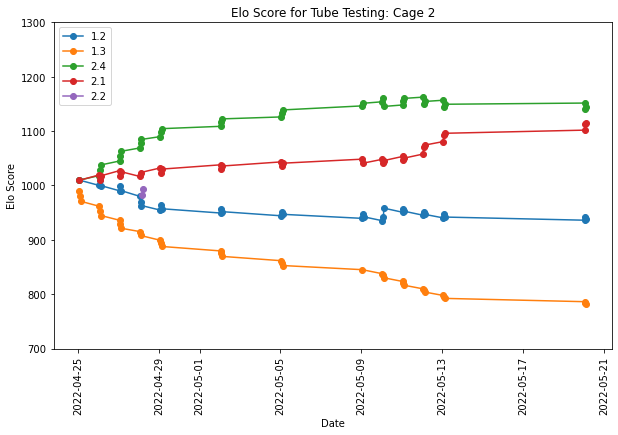

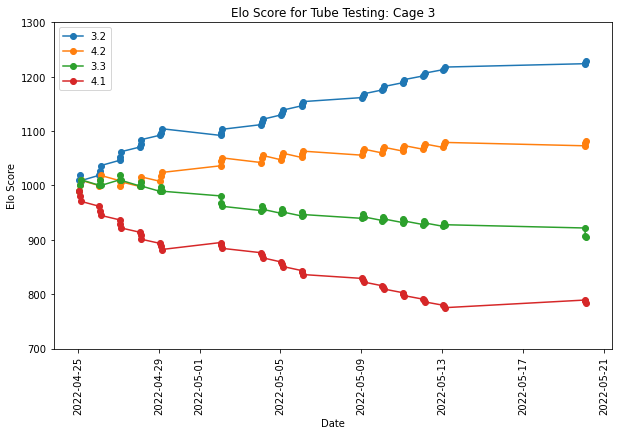

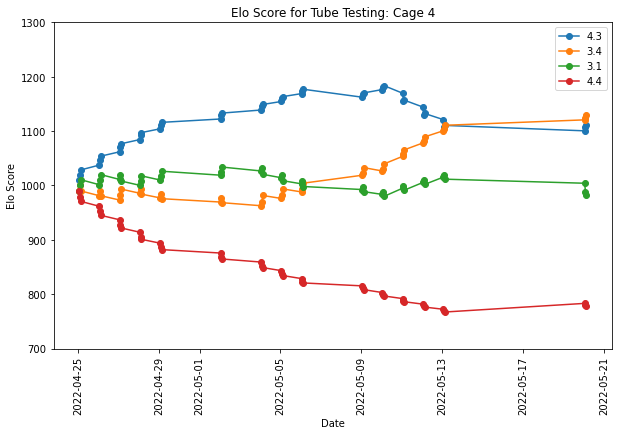

In [68]:
# Plotting for each cage
for cage in elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = elo_score_df[elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject_id"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Tube Testing: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(700, 1300) 
    file_name = "tube_testing_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/tube_testing", file_name))
